# Proyecto Inteligencia Computacional - Proyecto 8 - ID 8a

## Integrantes
- Juan Pablo Contreras
- Pascual Marcone

## Ayudante
- Sebastian Guzman

# Dependencias

In [1]:
#libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
from torch.utils.data import TensorDataset
importlib.reload(src)

<module 'src' (namespace) from ['/home/juanpablo/universidad/proyecto/ZTF_alert_8a/src']>

# Data access

In [2]:
#load everything
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')
# dataset_1_21 = pd.read_pickle('data/stamp_dataset_21_new.pkl')
# dataset_2_28 = pd.read_pickle('data/stamp_dataset_28.pkl')
# dataset_2_45 = pd.read_pickle('data/stamp_dataset_45.pkl')
# dataset_1_45 = pd.read_pickle('data/stamp_dataset_jun_allwise_45_final.pkl')
# dataset_2_63 = pd.read_pickle('data/stamp_dataset_only_images_63.pkl')
# dataset_1_63 = pd.read_pickle('data/td_ztf_stamp_17_06_20.pkl')

In [3]:
#changing all labels to match for ease of use in the future
def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

# apply the function to 
rename_labels(stamps_dataset, 'labels', 'class')
# rename_labels(dataset_1_63, 'labels', 'class')
rename_labels(stamps_dataset, 'science', 'images')

In [49]:
from torch.utils.data import TensorDataset

def generate_gaussian_image(size, center, sigma=1.0, noise_level=0.1, brightness=1.0):
    """Genera una imagen de tamaño `size` con una distribución gaussiana centrada en `center`."""
    x = np.linspace(0, size-1, size)
    y = np.linspace(0, size-1, size)
    x, y = np.meshgrid(x, y)
    d = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    g = np.exp(-(d**2 / (2.0 * sigma**2)))
    
    # Ajustar el brillo
    g *= brightness
    
    # Agregar ruido uniforme
    noise = np.random.uniform(-noise_level, noise_level, g.shape)
    g += noise
    
    # Asegurarse de que los valores estén en el rango [0, 1]
    g = np.clip(g, 0, 1)
    
    return g

def generate_gaussian_dataset(num_samples, image_size, border_margin=3, noise_level=0.1, brightness=1.0):
    """Genera un dataset de imágenes gaussianas con centros aleatorios."""
    images = []
    for _ in range(num_samples):
        center = (np.random.randint(border_margin, image_size - border_margin), 
                  np.random.randint(border_margin, image_size - border_margin))
        image = generate_gaussian_image(image_size, center, noise_level=noise_level, brightness=brightness)
        images.append(image)
    images = np.array(images)
    images = images[:, np.newaxis, :, :]  # Añadir una dimensión para el canal
    return torch.tensor(images, dtype=torch.float32)

# Parámetros del dataset
num_samples = 12800
image_size = 21
border_margin = 4
noise_level = 0.12
brightness = 0.7

# Generar el dataset
gaussian_images = generate_gaussian_dataset(num_samples, image_size, border_margin, noise_level, brightness)

# Crear un TensorDataset
gaussian_dataset = TensorDataset(gaussian_images)

# Verificar el tamaño del dataset
print(f"Dataset size: {len(gaussian_dataset)}")
print(f"Image shape: {gaussian_dataset[0][0].shape}")

# Visualizar algunas imágenes
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image = dataset[i][0].numpy().squeeze()  # Convertir a numpy y eliminar la dimensión del canal
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

# Mostrar 10 imágenes del dataset
show_images(gaussian_dataset, num_images=5)

## Data Characterization

In [5]:
from anytree import Node, RenderTree

# stamps_dataset
root = Node(f"stamps_dataset -- {stamps_dataset['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("labels", parent=train)
images = Node("images", parent=train)
template = Node("template", parent=train)
difference = Node("difference", parent=train)

s_labels = Node("labels", parent=validation)
s_images = Node("images", parent=validation)
s_template = Node("template", parent=validation)
s_difference = Node("difference", parent=validation)

t_labels = Node("labels", parent=test)
t_images = Node("images", parent=test)
t_template = Node("template", parent=test)
t_difference = Node("difference", parent=test)

# Render the tree
for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

stamps_dataset -- (123227, 5, 21, 21)
├── Train
│   ├── labels
│   ├── images
│   ├── template
│   └── difference
├── validation
│   ├── labels
│   ├── images
│   ├── template
│   └── difference
└── Test
    ├── labels
    ├── images
    ├── template
    └── difference




# Visualizacion Datos

Analizando algunos ejemplos de cada una

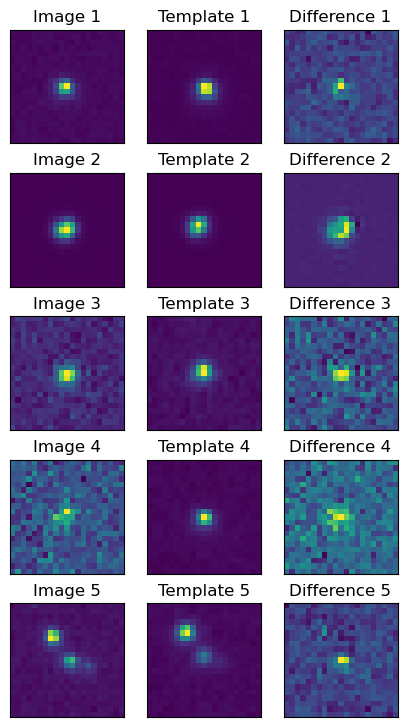

In [6]:
import src.plots as plots
importlib.reload(plots)

plots.plot_example(stamps_dataset, n = 5)

# Data Loader

In [7]:
train_difference = torch.tensor(stamps_dataset['Train']['difference'], dtype=torch.float32)
train_class = torch.tensor(stamps_dataset['Train']['class'], dtype=torch.float32)

validation_difference = torch.tensor(stamps_dataset['Validation']['difference'], dtype=torch.float32)
validation_class = torch.tensor(stamps_dataset['Validation']['class'], dtype=torch.float32)

test_difference = torch.tensor(stamps_dataset['Test']['difference'], dtype=torch.float32)
test_class = torch.tensor(stamps_dataset['Test']['class'], dtype=torch.float32)

# Reshape the arrays
num_samples, num_photos, height, width = train_difference.shape

reshaped_train_difference = train_difference.reshape(num_samples * num_photos, 1, height, width)
reshaped_train_class = train_class.repeat_interleave(num_photos)

num_samples, num_photos, height, width = validation_difference.shape

reshaped_val_difference = validation_difference.reshape(validation_difference.shape[0] * num_photos, 1, height, width)
reshaped_val_class = validation_class.repeat_interleave(num_photos)

num_samples, num_photos, height, width = test_difference.shape

reshaped_test_difference = test_difference.reshape(test_difference.shape[0] * num_photos, 1, height, width)
reshaped_test_class = test_class.repeat_interleave(num_photos)

train_dataset = TensorDataset(reshaped_train_difference, reshaped_train_class)
validation_dataset = TensorDataset(reshaped_val_difference, reshaped_val_class)
test_dataset = TensorDataset(reshaped_test_difference, reshaped_test_class)

print(train_dataset)

# Entrenamiento de Modelo

In [54]:
import src.model.train as train
importlib.reload(train)
import src.model.metrics as metrics
importlib.reload(metrics)
import src.model.vae as vae
importlib.reload(vae)

<module 'src.model.vae' from '/home/juanpablo/universidad/proyecto/ZTF_alert_8a/src/model/vae.py'>

In [52]:
#datasets de modelos
indices1 = torch.randperm(len(reshaped_train_difference))[:500]
indices2 = torch.randperm(len(reshaped_train_difference))[:1000]
indices3 = torch.randperm(len(reshaped_train_difference))[:4000]
indices4 = torch.randperm(len(reshaped_train_difference))[:8000]
indices5 = torch.randperm(len(reshaped_train_difference))[:15000]

train_dataset_1 = TensorDataset(reshaped_train_difference[indices1], reshaped_train_class[indices1])

train_dataset_2 = TensorDataset(reshaped_train_difference[indices2], reshaped_train_class[indices2])

train_dataset_3 = TensorDataset(reshaped_train_difference[indices3], reshaped_train_class[indices3])

train_dataset_4 = TensorDataset(reshaped_train_difference[indices4], reshaped_train_class[indices4])

train_dataset_5 = TensorDataset(reshaped_train_difference[indices5], reshaped_train_class[indices5])

In [ ]:
model_0 = vae.VAE(latent_dim=21)
model_1 = vae.VAE(latent_dim=21)
model_2 = vae.VAE(latent_dim=21)
model_3 = vae.VAE(latent_dim=21)
model_4 = vae.VAE(latent_dim=21)
model_5 = vae.VAE(latent_dim=21)

max_epochs = 100
criterion = vae.loss_function
batch_size = 128
lr = 1e-4
early_stop = 20
use_gpu = False

curves_1, tiempo_ejecucion_1 = train.train_model(model_1,
                                            train_dataset_1,
                                            validation_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu)

curves_2, tiempo_ejecucion_2 = train.train_model(model_2,
                                            train_dataset_2,
                                            validation_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu)

curves_3, tiempo_ejecucion_3 = train.train_model(model_3,
                                            train_dataset_3,
                                            validation_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu)

curves_4, tiempo_ejecucion_4 = train.train_model(model_4,
                                            train_dataset_4,
                                            validation_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu)

curves_5, tiempo_ejecucion_5 = train.train_model(model_5,
                                            train_dataset_5,
                                            validation_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu)

print(f'\nTiempo de ejecución -- model_1:{tiempo_ejecucion_1:.2f} -- model_2:{tiempo_ejecucion_2:.2f} -- model_3:{tiempo_ejecucion_3:.2f} -- model_4:{tiempo_ejecucion_4:.2f} -- model_5:{tiempo_ejecucion_5:.2f}')

Training model: epoch 0 out of 100

Training model: epoch 99 out of 100

Training model: epoch 99 out of 100

Training model: epoch 55 out of 100

In [ ]:
metrics.show_loss(curves_1, curves_2, curves_3, curves_4, curves_5)

In [89]:
import src.plots as plots
importlib.reload(plots)

# Select an image from the dataset
image = dataset_1_21['Train']['images'][1, :, :, 0]
vector = dataset_1_21['Train']['features'][0]
# Convert the image to a tensor
image_tensor = torch.tensor(image, dtype=torch.float32)
# Add a batch dimension and channel dimension to the image tensor
image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)

# Create a DataLoader for the image tensor
image_loader = torch.utils.data.DataLoader(image_tensor, batch_size=1)


reconstructed_image = model.forward(image_tensor)

plots.plot_two_images(image, reconstructed_image[0][0][0].detach().numpy())

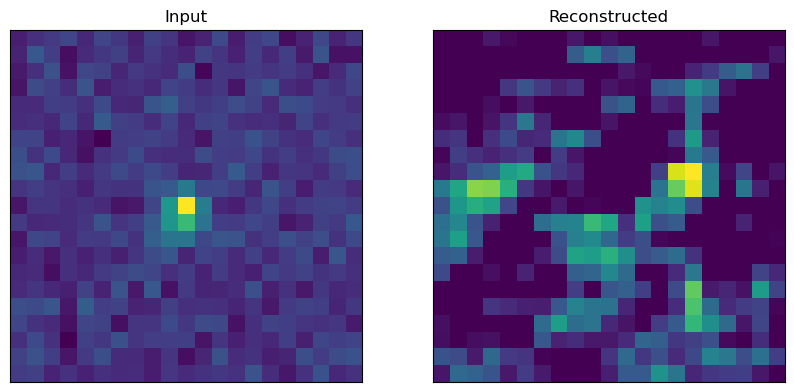

In [209]:
import src.plots as plots
importlib.reload(plots)

# Select an image from the dataset
image = dataset_1_21['Train']['images'][1, :, :, 0]
vector = dataset_1_21['Train']['features'][0]
# Convert the image to a tensor
image_tensor = torch.tensor(image, dtype=torch.float32)
# Add a batch dimension and channel dimension to the image tensor
image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)

# Create a DataLoader for the image tensor
image_loader = torch.utils.data.DataLoader(image_tensor, batch_size=1)

import src.model.vae as vae
importlib.reload(vae)

model = vae.VAE(latent_dim=21)

reconstructed_image = model.forward(image_tensor)

plots.plot_two_images(image, reconstructed_image[0][0][0].detach().numpy())

In [ ]:
def plot_example(models, datasets, sample='random', n=1):
    if sample == 'random':
        sample = [np.random.choice(len(dataset), n) for dataset in datasets]
    else:
        n = len(sample[0])

    for i in range(n):
        fig, axes = plt.subplots(1, len(models) * 2, figsize=(5 * len(models) * 2, 5))
        
        for j, (model, dataset) in enumerate(zip(models, datasets)):
            img = dataset[sample[j][i]][0].numpy().squeeze()  # Obtener la imagen original del dataset
            
            # Mostrar la imagen original
            axes[j * 2].imshow(img, cmap='gray')
            axes[j * 2].set_title(f'Model {j + 1} - Original')
            axes[j * 2].set_xticks([])
            axes[j * 2].set_yticks([])
            
            model.eval()
            with torch.no_grad():
                img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)  # Convertir la imagen a tensor
                reconstructed_img = model(img_tensor).squeeze().detach().numpy()
            
            axes[j * 2 + 1].imshow(reconstructed_img, cmap='gray')
            axes[j * 2 + 1].set_title(f'Model {j + 1} - Reconstructed')
            axes[j * 2 + 1].set_xticks([])
            axes[j * 2 + 1].set_yticks([])
    
        plt.show()
        
models = [model_1, model_2, model_3, model_4, model_5]  
datasets = stamps_dataset